# W205 Project 3
## AGM Business Improvement

### Team Members
#### Siddhartha Gupte
#### Kumar Kallurupalli
#### Tigran Poladian

Data science demonstration for the AGM data science team using the BART transportation system.

### BART TRACK LAYOUT

![Bart Map](../data/bart_map.png)

In [ ]:
pip install geopy

In [1]:
import neo4j
import csv
import math
import numpy as np
import pandas as pd

import psycopg2

import pymongo

import json

import geopy
from geopy.geocoders import Nominatim

from matplotlib import pyplot as plt

### Support Functions
Reused from W205 Code / Labs

In [2]:
connection = psycopg2.connect(
    user = "postgres",
    password = "ucb",
    host = "postgres",
    port = "5432",
    database = "postgres"
)

cursor = connection.cursor()

In [3]:
#
# function to run a select query and return rows in a pandas dataframe
# pandas puts all numeric values from postgres to float
# if it will fit in an integer, change it to integer
#

def my_select_query_pandas(query, rollback_before_flag, rollback_after_flag):
    "function to run a select query and return rows in a pandas dataframe"
    
    if rollback_before_flag:
        connection.rollback()
    
    df = pd.read_sql_query(query, connection)
    
    if rollback_after_flag:
        connection.rollback()
    
    # fix the float columns that really should be integers
    
    for column in df:
    
        if df[column].dtype == "float64":

            fraction_flag = False

            for value in df[column].values:
                
                if not np.isnan(value):
                    if value - math.floor(value) != 0:
                        fraction_flag = True

            if not fraction_flag:
                df[column] = df[column].astype('Int64')
    
    return(df)

In [4]:
def my_read_csv_file(file_name, limit):
    "read the csv file and print only the first limit rows"
    
    csv_file = open(file_name, "r")
    
    csv_data = csv.reader(csv_file)
    
    i = 0
    
    for row in csv_data:
        i += 1
        if i <= limit:
            print(row)
            
    print("\nPrinted ", min(limit, i), "lines of ", i, "total lines.")

### Drop tables, create and load from CSV files

In [5]:
connection.rollback()

query = """

drop table if exists stations;
"""

cursor = connection.cursor()
cursor.execute(query)

connection.commit()

In [6]:
connection.rollback()

query = """

drop table if exists lines;

"""

cursor = connection.cursor()
cursor.execute(query)

connection.commit()

In [7]:
connection.rollback()

query = """

drop table if exists travel_times;

"""

cursor = connection.cursor()
cursor.execute(query)

connection.commit()

In [8]:
connection.rollback()

query = """

create table stations (
    station varchar(32),
    latitude numeric(9,6),
    longitude numeric(9,6),
    transfer_time numeric(3),
    primary key (station)
);

"""

cursor = connection.cursor()
cursor.execute(query)

connection.commit()

In [9]:
connection.rollback()

query = """

create table lines (
    line varchar(6),
    sequence numeric(2),
    station varchar(32),
    primary key (line, sequence)
);

"""

cursor = connection.cursor()
cursor.execute(query)

connection.commit()

In [10]:
connection.rollback()

query = """

create table travel_times (
    station_1 varchar(32),
    station_2 varchar(32),
    travel_time numeric(3),
    primary key (station_1, station_2)
);

"""

cursor = connection.cursor()
cursor.execute(query)

connection.commit()

In [11]:
# NOTE: use location of data files
connection.rollback()

query = """

copy stations
from '/user/projects/w205_project3/data/stations.csv' delimiter ',' NULL '' csv header;

"""

cursor = connection.cursor()
cursor.execute(query)

connection.commit()

In [12]:
connection.rollback()

query = """

copy lines
from '/user/projects/w205_project3/data/lines.csv' delimiter ',' NULL '' csv header;

"""

cursor = connection.cursor()
cursor.execute(query)

connection.commit()

In [13]:
connection.rollback()

query = """

copy travel_times
from '/user/projects/w205_project3/data/travel_times.csv' delimiter ',' NULL '' csv header;

"""

cursor = connection.cursor()
cursor.execute(query)

connection.commit()

### Establish Neo4j connection and helper functions

In [14]:
driver = neo4j.GraphDatabase.driver(uri="neo4j://neo4j:7687", auth=("neo4j","w205"))
session = driver.session(database="neo4j")

geolocator = Nominatim(user_agent="geoapiExercises")

In [15]:
def my_neo4j_wipe_out_database():
    "wipe out database by deleting all nodes and relationships"
    
    query = "match (node)-[relationship]->() delete node, relationship"
    session.run(query)
    
    query = "match (node) delete node"
    session.run(query)
  
def my_neo4j_run_query_pandas(query, **kwargs):
    "run a query and return the results in a pandas dataframe"
    
    result = session.run(query, **kwargs)
    
    df = pd.DataFrame([r.values() for r in result], columns=result.keys())
    
    return df

def my_neo4j_create_node(station_name):
    "create a node with label Station"
    
    query = """
    
    CREATE (:Station {name: $station_name})
    
    """
    
    session.run(query, station_name=station_name)

def my_neo4j_create_relationship_one_way(from_station, to_station, weight):
    "create a relationship one way between two stations with a weight"
    
    query = """
    
    MATCH (from:Station), 
          (to:Station)
    WHERE from.name = $from_station and to.name = $to_station
    CREATE (from)-[:LINK {weight: $weight}]->(to)
    
    """
    
    session.run(query, from_station=from_station, to_station=to_station, weight=weight)

def my_neo4j_create_relationship_two_way(from_station, to_station, weight):
    "create relationships two way between two stations with a weight"
    
    query = """
    
    MATCH (from:Station), 
          (to:Station)
    WHERE from.name = $from_station and to.name = $to_station
    CREATE (from)-[:LINK {weight: $weight}]->(to),
           (to)-[:LINK {weight: $weight}]->(from)
    
    """
    
    session.run(query, from_station=from_station, to_station=to_station, weight=weight)


In [16]:
my_neo4j_wipe_out_database()

### Begin PROJECT 3 CODE HERE

#### Project To Do
1. Add modules to injest real time traffic data (use Redis or Redis fixed document as a proxy)
2. Import train schedules, planned route outages (use MongoDB)
3. Based on 1 and 2 create new graphs or modify cost / weights across nodes on existing graphs to eliminate paths and change time cost across nodes
4. Create 3 or more search, sort algorithms. Use the above as a template
5. Overlay Google maps API


#### Business Scenario 1

Select customers from the customers table who are within the BART transportation region

Run EDA using neo4j
   * Find clusters of customers, where concentrated most
   * Find nearest and furthest BART station to the clusters
   * Recommend pop up stores and new permanent locations

In [17]:
# ***********************************************************************************************************************
# Business Scenario 1
#
# Pseudocode:
#
# 1. Get list of unique zip codes associated to the set of BART stations using lat lon of station locations
#   -- lat lon from station table
# 2. From the customers table, find all customers with zip codes in the list of zip codes
# 3. Prepare histogram of customer counts per zip code
# 4. Create neo4j graph of nodes for zip codes along with graph of stations 
#   -- connect zip code nodes to station nodes with links indicating distance so distance from zip to station within 
#      same zip should be 0
#   -- refine further ... use customer address (and google maps api?) to compute actual distance to each BART station
# 5. Can we use any of the centrality type measures for this scenario?
# 6. refine further ... use customer address (and google maps api?) to compute actual distance to each BART station
#
# Notes:
#   Reverse zip code locator code from: 
#   https://www.geeksforgeeks.org/find-the-location-with-specified-latitude-and-longitude-using-python/
#   https://www.geeksforgeeks.org/get-the-city-state-and-country-names-from-latitude-and-longitude-using-python/?ref=rp
# **********************************************************************************************************************

def neo4j_create_node(station_name,zip_code="",tt=0,pop=0,lat=0,lon=0):
    "create a node with label Station"

    query = """
    
    CREATE (:Station {name: $station_name, zip: $zip_code, pop: $pop, transfer_time: $tt,latitude: $lat, longitude: $lon})
    
    """
    
    session.run(query, station_name=station_name,zip_code=zip_code,pop=pop,tt=tt,lat=lat,lon=lon)
    
def find_customer_count(zipcode):
    connection.rollback()

    rollback_before_flag = True
    rollback_after_flag = True

    query = """ 
    select zip, count(*)
    from customers
    where zip = '%s'
    group by zip
    order by zip
    """.replace("%s",zipcode)
    
    df_count = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
    
    return df_count['count']


def neo4j_create_station():
    connection.rollback()

    query = """

    select station, latitude, longitude, transfer_time
    from stations
    order by station

    """

    cursor.execute(query)

    connection.rollback()

    rows = cursor.fetchall()

    for row in rows:
    
        station = row[0]
        lat = row[1]
        lon = row[2]
        tt = row[3]
        
        # Find Zip code
        location = geolocator.reverse(str(lat)+","+str(lon))
        address = location.raw['address']
        zipcode = address.get('postcode')
        
        # Find number of customers
        #if zipcode == None:
        #    pop = 0
        #else:
        #    pop = find_customer_count(zipcode)
        
        #neo4j_create_node(station,zipcode,str(tt),str(pop))
        neo4j_create_node(station,zipcode,str(tt),0,str(lat),str(lon))

def neo4j_create_zip_node(node_name, attr):
    "create a node with label Station"
    
    #query = "\"\" CREATE (:"+str(attr)+" {name: " + str(node_name) + "}) \"\" "
    
    query = """
    CREATE (:Zip {name: $name})
    """
    
    session.run(query,name=node_name)

def neo4j_create_relationship_one_way(from_node, to_node, weight):
    "create a relationship one way between two stations with a weight"
    
    query = """
    
    MATCH (from:Zip), 
          (to:Zip)
    WHERE from.name = $from_node and to.name = $to_node
    CREATE (from)-[:TRACK {weight: $weight}]->(to)
    
    """
    
    session.run(query, from_node=from_node, to_node=to_node, weight=weight)

def get_station_name_by_zip(zipcode):
    query = """
    
    MATCH(n:Station {zip: $zipcode}) 
    RETURN n.name
    """
    
    res = session.run(query, zipcode=zipcode)
        
    return([record["n.name"] for record in res])

def neo4j_add_pop_attribute(node_name, pop_value):
    
    #print(node_name[0])
    #query = """
    
    #MATCH(n:Station {name: $node_name}) 
    #SET n.pop = $pop_value
    #"""

    #session.run(query, node_name=node_name, pop_value=pop_value)
    
    query = """
    
    MATCH(n:Station {name: '%s'}) 
    SET n.pop = '%t'
    """.replace("%s",str(node_name[0])).replace("%t",str(pop_value))
    
    #print(query)
    session.run(query)

def neo4j_find_travel_time(station1, station2):
    print(str(station1) + "," + str(station2))
    connection.rollback()

    rollback_before_flag = True
    rollback_after_flag = True

    query = """ 
    select travel_time
    from travel_times
    where (station_1 = '%s1' and station_2 = '%s2') or (station_1 = '%s2' and station_2 = '%s1')
    """.replace("%s1",station1).replace("%s2",station2)
    
    df_tt = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
    
    print(df_tt['travel_time'][0])
    return (df_tt['travel_time'][0])

In [ ]:
# *********************************************************
# UNIT TEST
# *********************************************************
neo4j_find_travel_time("MacArthur", "Ashby")

In [18]:
# ***********************************************************************************************************************
# 1. Get list of unique zip codes associated to the set of BART stations using lat lon of station locations
#   -- lat lon from station table
# ***********************************************************************************************************************

connection.rollback()

query = """

select latitude, longitude, station
from stations

"""
cursor.execute(query)
connection.rollback()
rows = cursor.fetchall()

zips = []

for i, row in enumerate(rows):
    location = geolocator.reverse(str(row[0])+","+str(row[1]))
    address = location.raw['address']
    #city = address.get('city', '')
    #state = address.get('state', '')
    #country = address.get('country', '')
    #code = address.get('country_code')
    zipcode = address.get('postcode')
    #print(i)
    #print('City : ',city)
    #print('State : ',state)
    #print('Country : ',country)
    #print('Zip Code : ', zipcode)
    
    if zipcode == None:
      continue
    zips.append(zipcode)
    
zips_unique = set(zips)
print(zips_unique)

{'94143', '94601', '94703', '94104', '95035', '94549', '94804', '94536', '95133', '94612', '94541', '94565', '94111', '94596', '94702', '94609', '94587', '94066', '94614', '94563', '94112', '94580', '94014', '94704', '94102', '90104', '94128', '94015', '94539', '94577', '94621', '94520', '94530', '94030', '94509', '94168', '94080', '90103', '94607', '94544', '94597', '94588'}


In [19]:
# ***********************************************************************************************************************
# 2. From the customers table, find all customers with zip codes in the list of zip codes
# ***********************************************************************************************************************
#print(zips_unique)
#print(zips)

zip_list = ''
for z in zips_unique:
    zip_list += '\'' + str(z) + '\'' + ','

zip_list = zip_list[:-1] # remove extra last comma

rollback_before_flag = True
rollback_after_flag = True

query = """ 
select zip, count(*)
from customers
where zip in (%s)
group by zip
order by zip
""".replace("%s",zip_list)

df_customers = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
df_customers

,zip,count
0,94014,41
1,94015,4
2,94030,10
3,94066,9
4,94080,9
5,94102,78
6,94104,5
7,94111,36
8,94112,40
9,94128,1


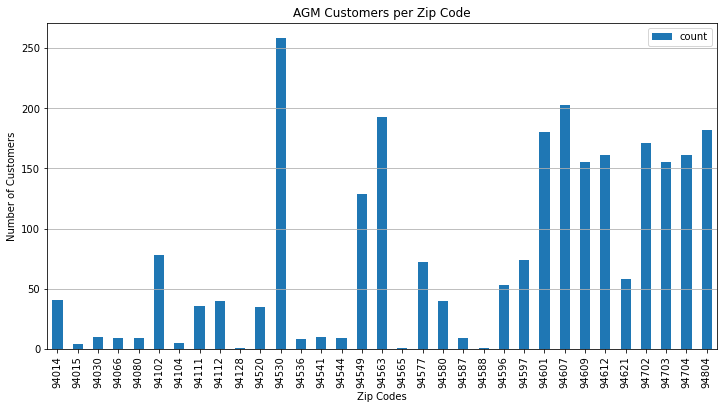

In [20]:
# ***********************************************************************************************************************
# 3. Prepare barplot of customer counts per zip code
# **********************************************************************************************************************

df_customers.set_index(df_customers['zip'],inplace=True)
df_customers.plot(kind='bar',figsize=(12,6),title='AGM Customers per Zip Code').grid(axis='y')
plt.xlabel('Zip Codes')
plt.ylabel('Number of Customers')
plt.xticks(rotation=90)
plt.show()

In [21]:
# **********************************************************************************************************************
# 4a. Create neo4j graph of nodes for zip codes along with graph of stations 
#   -- connect zip code nodes to station nodes with links indicating distance so distance from zip to station within 
#      same zip should be 0
#   
# **********************************************************************************************************************
#my_neo4j_wipe_out_database()
neo4j_create_station()

In [22]:
# **********************************************************************************************************************
# 4b. Add zip code to each station node based on station name 
# **********************************************************************************************************************
for i,z in enumerate(df_customers['zip']):
    #neo4j_create_node(z,"Count")
    #neo4j_create_relationship_one_way(z, z, str(df_customers['count'][i]))
   
    node_name = get_station_name_by_zip(z)
    pop_value = str(df_customers['count'][i])
    
    #print(pop_value)
    neo4j_add_pop_attribute(node_name, pop_value)


In [23]:
def neo4j_create_relationship(from_node, to_node, color, weight):
    "create a relationship between two stations with a weight:travel time"
    
    if color == 'blue':
        query = """
    
        MATCH (from:Station), 
          (to:Station)
        WHERE from.name = $from_node and to.name = $to_node
        CREATE (to)-[:BLUE {weight: $weight}]->(from)-[:BLUE {weight: $weight}]->(to)
    
        """
    elif color == 'gray':
        query = """
    
        MATCH (from:Station), 
          (to:Station)
        WHERE from.name = $from_node and to.name = $to_node
        CREATE (to)-[:GRAY {weight: $weight}]->(from)-[:GRAY {weight: $weight}]->(to)
    
        """
    elif color == 'green':
        query = """
    
        MATCH (from:Station), 
          (to:Station)
        WHERE from.name = $from_node and to.name = $to_node
        CREATE (to)-[:GREEN {weight: $weight}]->(from)-[:GREEN {weight: $weight}]->(to)
    
        """
    
    elif color == 'orange':
        query = """
    
        MATCH (from:Station), 
          (to:Station)
        WHERE from.name = $from_node and to.name = $to_node
        CREATE (to)-[:ORANGE {weight: $weight}]->(from)-[:ORANGE {weight: $weight}]->(to)
    
        """
    
    elif color == 'red':
        query = """
    
        MATCH (from:Station), 
          (to:Station)
        WHERE from.name = $from_node and to.name = $to_node
        CREATE (to)-[:RED {weight: $weight}]->(from)-[:RED {weight: $weight}]->(to)
    
        """
    
    elif color == 'yellow':
        query = """
    
        MATCH (from:Station), 
          (to:Station)
        WHERE from.name = $from_node and to.name = $to_node
        CREATE (to)-[:YELLOW {weight: $weight}]->(from)-[:YELLOW {weight: $weight}]->(to)
    
        """
    
    else:
        return
    
    session.run(query, from_node=from_node, to_node=to_node, weight=weight)

In [ ]:
def neo4j_create_relationship_noline(from_node, to_node, weight):
    "create a relationship between two stations with a weight:travel time"
    
    query = """
    
    MATCH (from:Station), 
        (to:Station)
    WHERE from.name = $from_node and to.name = $to_node
    CREATE (to)-[:TRACK {weight: $weight}]->(from)-[:TRACK {weight: $weight}]->(to)
    
    """

    session.run(query, from_node=from_node, to_node=to_node, weight=weight)

In [ ]:
# *****************************************
# UNIT TEST
# *****************************************
neo4j_create_relationship("Ashby", "MacArthur", "red", 80)

In [ ]:
# *****************************************
# UNIT TEST
# *****************************************
neo4j_create_relationship_noline("Ashby", "MacArthur", 80)

In [24]:
# **********************************************************************************************************************
# 4c. Link stations, travel time and line color attribute to links
# **********************************************************************************************************************
line_colors = ['blue','gray','green','orange','red','yellow']

connection.rollback()

rollback_before_flag = True
rollback_after_flag = True

for lc in line_colors:
    query = """ 
    select sequence, station
    from lines
    where line = '%s'
    """.replace("%s",lc)
    
    df_line = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
    df_line
    cnt = len(df_line['station'])
    #print(lc)
    #print("COUNT: " + str(cnt))
    if cnt > 1:
        for i in range (cnt-1):
            #print(df_line['station'][i])
            #print(df_line['station'][i+1])
            stn1 = df_line['station'][i]
            stn2 = df_line['station'][i+1]
            
            #print(str(stn1) + "," + str(stn2))
            
            tt = neo4j_find_travel_time(stn1, stn2)
            
            #print(tt)
            neo4j_create_relationship(stn1,stn2,lc,int(tt))
            #neo4j_create_relationship_noline(stn1,stn2,int(tt))
    else:
        continue
        

Dublin,West Dublin
180
West Dublin,Castro Valley
600
Castro Valley,Bay Fair
240
Bay Fair,San Leandro
240
San Leandro,Coliseum
240
Coliseum,Fruitvale
240
Fruitvale,Lake Merritt
300
Lake Merritt,West Oakland
360
West Oakland,Embarcadero
420
Embarcadero,Montgomery Street
60
Montgomery Street,Powell Street
120
Powell Street,Civic Center
60
Civic Center,16th Street Mission
180
16th Street Mission,24th Street Mission
120
24th Street Mission,Glen Park
180
Glen Park,Balboa Park
120
Balboa Park,Daly City
240
OAK,Coliseum
480
Berryessa,Milpitas
300
Milpitas,Warm Springs
540
Warm Springs,Fremont
360
Fremont,Union City
300
Union City,South Hayward
300
South Hayward,Hayward
240
Hayward,Bay Fair
240
Bay Fair,San Leandro
240
San Leandro,Coliseum
240
Coliseum,Fruitvale
240
Fruitvale,Lake Merritt
300
Lake Merritt,West Oakland
360
West Oakland,Embarcadero
420
Embarcadero,Montgomery Street
60
Montgomery Street,Powell Street
120
Powell Street,Civic Center
60
Civic Center,16th Street Mission
180
16th Stree

#### SEARCH ALGORITHMS

In [25]:
# **********************************************************************************************************************
# 5. Data Science algorithms
# **********************************************************************************************************************

# ************************************************************************************************************
# Shortest Path algorithm dijkstra
# ************************************************************************************************************
def neo4j_shortest_path(from_station, to_station, line):
    "given a from station and to station, run and print the shortest path"
    
    query = "CALL gds.graph.drop('ds_graph', false)"
    session.run(query)

    if line == 'BLUE':
        query = "CALL gds.graph.project('ds_graph', 'Station', 'BLUE', {relationshipProperties: 'weight'})"
    elif line == 'RED':
        query = "CALL gds.graph.project('ds_graph', 'Station', 'RED', {relationshipProperties: 'weight'})"
    elif line == 'ORANGE':
        query = "CALL gds.graph.project('ds_graph', 'Station', 'ORANGE', {relationshipProperties: 'weight'})"
    elif line == 'YELLOW':
        query = "CALL gds.graph.project('ds_graph', 'Station', 'YELLOW', {relationshipProperties: 'weight'})"
    elif line == 'GREEN':
        query = "CALL gds.graph.project('ds_graph', 'Station', 'GREEN', {relationshipProperties: 'weight'})"
    elif line == 'GRAY':
        query = "CALL gds.graph.project('ds_graph', 'Station', 'GRAY', {relationshipProperties: 'weight'})"
    else:
        return
        
    session.run(query)

    query = """

    MATCH (source:Station {name: $source}), (target:Station {name: $target})
    CALL gds.shortestPath.dijkstra.stream(
        'ds_graph', 
        { sourceNode: source, 
          targetNode: target, 
          relationshipWeightProperty: 'weight'
        }
    )
    YIELD index, sourceNode, targetNode, totalCost, nodeIds, costs, path
    RETURN
        gds.util.asNode(sourceNode).name AS from,
        gds.util.asNode(targetNode).name AS to,
        totalCost,
        [nodeId IN nodeIds | gds.util.asNode(nodeId).name] AS nodes,
        costs
    ORDER BY index

    """

    result = session.run(query, source=from_station, target=to_station)
    
    for r in result:
        
        total_cost = int(r['totalCost'])
        
        print("\n--------------------------------")
        print("   Total Cost: ", total_cost)
        print("   Minutes: ", round(total_cost / 60.0,1))
        print("--------------------------------")
        
        nodes = r['nodes']
        costs = r['costs']
        
        i = 0
        previous = 0
        
        for n in nodes:
            
            print(n + ", " + str(int(costs[i]) - previous)  + ", " + str(int(costs[i])))
            
            previous = int(costs[i])
            i += 1      

In [26]:
# **********************************************************************************************************************
# 5. Data Science algorithms
# **********************************************************************************************************************
neo4j_shortest_path("MacArthur","El Cerrito Plaza","ORANGE")



--------------------------------
   Total Cost:  720
   Minutes:  12.0
--------------------------------
MacArthur, 0, 0
Ashby, 240, 240
Downtown Berkeley, 180, 420
North Berkeley, 120, 540
El Cerrito Plaza, 180, 720


#### CENTRALITY ALGORITHMS

In [45]:
def neo4j_page_rank(line):
    "given a from station and to station, run and print the shortest path"
    
    query = "CALL gds.graph.drop('ds_graph', false)"
    session.run(query)

    if line == 'BLUE':
        query = "CALL gds.graph.project('ds_graph', 'Station', 'BLUE', {relationshipProperties: 'weight'})"
    elif line == 'RED':
        query = "CALL gds.graph.project('ds_graph', 'Station', 'RED', {relationshipProperties: 'weight'})"
    elif line == 'ORANGE':
        query = "CALL gds.graph.project('ds_graph', 'Station', 'ORANGE', {relationshipProperties: 'weight'})"
    elif line == 'YELLOW':
        query = "CALL gds.graph.project('ds_graph', 'Station', 'YELLOW', {relationshipProperties: 'weight'})"
    elif line == 'GREEN':
        query = "CALL gds.graph.project('ds_graph', 'Station', 'GREEN', {relationshipProperties: 'weight'})"
    elif line == 'GRAY':
        query = "CALL gds.graph.project('ds_graph', 'Station', 'GRAY', {relationshipProperties: 'weight'})"
    else:
        return
        
    session.run(query)
    
    query = """

    CALL gds.pageRank.stream('ds_graph')
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).name AS name, score
    ORDER BY score DESC, name ASC

    """
    
    result = session.run(query)
    
    print("Station Name : Station Rank Score")
    for r in result:
        name = r['name']
        score = float(r['score'])
        print(name," : ",score)

In [52]:
neo4j_page_rank("ORANGE")

Station Name : Station Rank Score
El Cerrito del Norte  :  1.117028020456166
Milpitas  :  1.117028020456166
El Cerrito Plaza  :  1.0464044032638091
Warm Springs  :  1.0464044032638091
Fremont  :  1.0080301302761208
North Berkeley  :  1.0080301302761208
Downtown Berkeley  :  0.9861698554157151
Union City  :  0.9861698554157151
Ashby  :  0.9747540843912642
South Hayward  :  0.9747540843912642
Hayward  :  0.9681078247112055
MacArthur  :  0.9681078247112055
19th Street  :  0.964911544427056
Bay Fair  :  0.964911544427056
12th Street  :  0.9630109378528724
San Leandro  :  0.9630109378528724
Coliseum  :  0.9623040781560552
Lake Merritt  :  0.9623040781560552
Fruitvale  :  0.961972609955909
Berryessa  :  0.6213177396843814
Richmond  :  0.6213177396843814
16th Street Mission  :  0.15000000000000002
24th Street Mission  :  0.15000000000000002
Antioch  :  0.15000000000000002
Balboa Park  :  0.15000000000000002
Castro Valley  :  0.15000000000000002
Civic Center  :  0.15000000000000002
Colma  :  0

In [55]:
def neo4j_between(line):
    "given a from station and to station, run and print the shortest path"
    
    query = "CALL gds.graph.drop('ds_graph', false)"
    session.run(query)

    if line == 'BLUE':
        query = "CALL gds.graph.project('ds_graph', 'Station', 'BLUE', {relationshipProperties: 'weight'})"
    elif line == 'RED':
        query = "CALL gds.graph.project('ds_graph', 'Station', 'RED', {relationshipProperties: 'weight'})"
    elif line == 'ORANGE':
        query = "CALL gds.graph.project('ds_graph', 'Station', 'ORANGE', {relationshipProperties: 'weight'})"
    elif line == 'YELLOW':
        query = "CALL gds.graph.project('ds_graph', 'Station', 'YELLOW', {relationshipProperties: 'weight'})"
    elif line == 'GREEN':
        query = "CALL gds.graph.project('ds_graph', 'Station', 'GREEN', {relationshipProperties: 'weight'})"
    elif line == 'GRAY':
        query = "CALL gds.graph.project('ds_graph', 'Station', 'GRAY', {relationshipProperties: 'weight'})"
    else:
        return
        
    session.run(query)
    
    query = """

    CALL gds.betweenness.stream('ds_graph')
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).name AS name, score
    ORDER BY score DESC, name ASC

    """
    
    result = session.run(query)
    
    print("Station Name : Betweenness Centrality")
    for r in result:
        name = r['name']
        score = float(r['score'])
        print(name," : ",score)

In [57]:
neo4j_between("GREEN")

Station Name : Betweenness Centrality
Fruitvale  :  220.0
Lake Merritt  :  220.0
Coliseum  :  216.0
West Oakland  :  216.0
Embarcadero  :  208.0
San Leandro  :  208.0
Bay Fair  :  196.0
Montgomery Street  :  196.0
Hayward  :  180.0
Powell Street  :  180.0
Civic Center  :  160.0
South Hayward  :  160.0
16th Street Mission  :  136.0
Union City  :  136.0
24th Street Mission  :  108.0
Fremont  :  108.0
Glen Park  :  76.0
Warm Springs  :  76.0
Balboa Park  :  40.0
Milpitas  :  40.0
12th Street  :  0.0
19th Street  :  0.0
Antioch  :  0.0
Ashby  :  0.0
Berryessa  :  0.0
Castro Valley  :  0.0
Colma  :  0.0
Concord  :  0.0
Daly City  :  0.0
Downtown Berkeley  :  0.0
Dublin  :  0.0
El Cerrito Plaza  :  0.0
El Cerrito del Norte  :  0.0
Lafayette  :  0.0
MacArthur  :  0.0
Millbrae  :  0.0
North Berkeley  :  0.0
North Concord  :  0.0
OAK  :  0.0
Orinda  :  0.0
Pittsburg  :  0.0
Pittsburg Center  :  0.0
Pleasant Hill  :  0.0
Richmond  :  0.0
Rockridge  :  0.0
SFO  :  0.0
San Bruno  :  0.0
South San 

In [60]:
def neo4j_degree(line):
    "given a from station and to station, run and print the shortest path"
    
    query = "CALL gds.graph.drop('ds_graph', false)"
    session.run(query)

    if line == 'BLUE':
        query = "CALL gds.graph.project('ds_graph', 'Station', 'BLUE', {relationshipProperties: 'weight'})"
    elif line == 'RED':
        query = "CALL gds.graph.project('ds_graph', 'Station', 'RED', {relationshipProperties: 'weight'})"
    elif line == 'ORANGE':
        query = "CALL gds.graph.project('ds_graph', 'Station', 'ORANGE', {relationshipProperties: 'weight'})"
    elif line == 'YELLOW':
        query = "CALL gds.graph.project('ds_graph', 'Station', 'YELLOW', {relationshipProperties: 'weight'})"
    elif line == 'GREEN':
        query = "CALL gds.graph.project('ds_graph', 'Station', 'GREEN', {relationshipProperties: 'weight'})"
    elif line == 'GRAY':
        query = "CALL gds.graph.project('ds_graph', 'Station', 'GRAY', {relationshipProperties: 'weight'})"
    else:
        return
        
    session.run(query)
    
    query = """

    CALL gds.degree.stream('ds_graph')
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).name AS name, score AS followers
    ORDER BY followers DESC, name DESC

    """
    
    result = session.run(query)
    
    print("Station Name : Followers")
    for r in result:
        name = r['name']
        score = float(r['followers'])
        print(name," : ",score)

In [62]:
neo4j_degree("RED")

Station Name : Followers
West Oakland  :  2.0
South San Francisco  :  2.0
San Bruno  :  2.0
Powell Street  :  2.0
North Berkeley  :  2.0
Montgomery Street  :  2.0
Millbrae  :  2.0
MacArthur  :  2.0
Glen Park  :  2.0
Embarcadero  :  2.0
El Cerrito del Norte  :  2.0
El Cerrito Plaza  :  2.0
Downtown Berkeley  :  2.0
Daly City  :  2.0
Colma  :  2.0
Civic Center  :  2.0
Balboa Park  :  2.0
Ashby  :  2.0
24th Street Mission  :  2.0
19th Street  :  2.0
16th Street Mission  :  2.0
12th Street  :  2.0
SFO  :  1.0
Richmond  :  1.0
West Dublin  :  0.0
Warm Springs  :  0.0
Walnut Creek  :  0.0
Union City  :  0.0
South Hayward  :  0.0
San Leandro  :  0.0
Rockridge  :  0.0
Pleasant Hill  :  0.0
Pittsburg Center  :  0.0
Pittsburg  :  0.0
Orinda  :  0.0
OAK  :  0.0
North Concord  :  0.0
Milpitas  :  0.0
Lake Merritt  :  0.0
Lafayette  :  0.0
Hayward  :  0.0
Fruitvale  :  0.0
Fremont  :  0.0
Dublin  :  0.0
Concord  :  0.0
Coliseum  :  0.0
Castro Valley  :  0.0
Berryessa  :  0.0
Bay Fair  :  0.0
Antioc

In [65]:
def neo4j_closeness(line):
    "given a from station and to station, run and print the shortest path"
    
    query = "CALL gds.graph.drop('ds_graph', false)"
    session.run(query)

    if line == 'BLUE':
        query = "CALL gds.graph.project('ds_graph', 'Station', 'BLUE', {relationshipProperties: 'weight'})"
    elif line == 'RED':
        query = "CALL gds.graph.project('ds_graph', 'Station', 'RED', {relationshipProperties: 'weight'})"
    elif line == 'ORANGE':
        query = "CALL gds.graph.project('ds_graph', 'Station', 'ORANGE', {relationshipProperties: 'weight'})"
    elif line == 'YELLOW':
        query = "CALL gds.graph.project('ds_graph', 'Station', 'YELLOW', {relationshipProperties: 'weight'})"
    elif line == 'GREEN':
        query = "CALL gds.graph.project('ds_graph', 'Station', 'GREEN', {relationshipProperties: 'weight'})"
    elif line == 'GRAY':
        query = "CALL gds.graph.project('ds_graph', 'Station', 'GRAY', {relationshipProperties: 'weight'})"
    else:
        return
        
    session.run(query)
    
    query = """

    CALL gds.beta.closeness.stream('ds_graph')
    YIELD nodeId, score
    RETURN gds.util.asNode(nodeId).name AS name, score
    ORDER BY score DESC

    """
    
    result = session.run(query)
    
    print("Station Name : Closeness")
    for r in result:
        name = r['name']
        score = float(r['score'])
        print(name," : ",score)

In [66]:
neo4j_closeness("YELLOW")

Station Name : Closeness
West Oakland  :  0.14285714285714285
12th Street  :  0.14207650273224043
Embarcadero  :  0.14207650273224043
19th Street  :  0.13978494623655913
Montgomery Street  :  0.13978494623655913
MacArthur  :  0.13612565445026178
Powell Street  :  0.13612565445026178
Civic Center  :  0.13131313131313133
Rockridge  :  0.13131313131313133
16th Street Mission  :  0.12560386473429952
Orinda  :  0.12560386473429952
24th Street Mission  :  0.11926605504587157
Lafayette  :  0.11926605504587157
Walnut Creek  :  0.11255411255411256
Glen Park  :  0.11255411255411256
Pleasant Hill  :  0.10569105691056911
Balboa Park  :  0.10569105691056911
Concord  :  0.09885931558935361
Daly City  :  0.09885931558935361
Colma  :  0.09219858156028368
North Concord  :  0.09219858156028368
Pittsburg  :  0.0858085808580858
South San Francisco  :  0.0858085808580858
Pittsburg Center  :  0.07975460122699386
San Bruno  :  0.07975460122699386
Antioch  :  0.07407407407407407
SFO  :  0.07407407407407407
So

#### Business Scenario 2

Given traffic congestion "real time" data, compute shortest BART transportation path to avoid congestion

* Import traffic data either from Redis or canned file
* Update weights on links to make congested paths more costly
* Run shortest path (or other) algorithms
   
 (Traffic congestion data -- extreme, high, medium, low as input feed. Update transit times by
 factors of 100, 10, 2, 1. Run route planning algorithm based on congestion.)


In [ ]:
# **********************************************************************************************************************
# Business Scenario 2
#
# Given traffic congestion "real time" data, compute shortest 
# BART transportation path to avoid congestion
#
# Import traffic data either from Redis or canned file
# Update weights on links to make congested paths more costly
# Run shortest path (or other) algorithms
#   
# (Traffic congestion data -- extreme, high, medium, low as input feed. Update transit times by
# factors of 100, 10, 2, 1. Run route planning algorithm based on congestion.)
# *********************************************************************************************************************

In [ ]:
# ADD SCENARIO 2

#### Business Scenario 3
Given scheduled station closures and track segment out of service, re-evaluate best locations for popup locations or perhaps deploy delivery robots to pick up from those locations not accessible to customers and bring products to open locations. For example, if Oakland marathon is running with street closures, customers cannot access some areas of the city.

* Import schedule file (from Redis, MongoDB or canned CSV file)
* Use file remove stations from neo4j however do not remove associated pickup location thereby causing a dangling node without a link.
* Deploy mobile robots to dangling nodes and deliver product to nearest open pickup location
* Compute next nearest location also accounting for removed Links due to planned track maintenance

In [ ]:
# *********************************************************************************************************************
# Business Scenario 3
#
# Given scheduled station closures and track segment out of service,  
# re-evaluate best locations for popup locations or perhaps deploy
# delivery robots to pick up from those locations not accessible to
# customers and bring products to open locations.  For example, if
# Oakland marathon is running with street closures, customers cannot 
# access some areas of the city.
#
# Import schedule file (from Redis, MongoDB or canned CSV file)
# Use file remove stations from neo4j however do not remove associated pickup location 
#   thereby causing a dangling node without a link.
# Deploy mobile robots to dangling nodes and deliver product to nearest open pickup location
# Compute next nearest location also accounting for removed Links due to planned
#   track maintenance
#   
# ********************************************************************************************************************

In [ ]:
# ADD SCENARIO 3